# Séance 2 - Calibration

On se propose dans ce notebook d'explorer une manière de recalibrer un modèle machine learning.
Pour le faire, nous allons travailler avec un dataset déséquilibré qui a pour but de prédire si une étoile est un pulsar ou non. On ne s'intéresse pas au travail de feature engineering ici.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

df = pd.read_csv("pulsar_stars.csv")
df.head()

,Mean_ip,Std_ip,Excess_kurtosis_ip,Skewness_ip,Mean_DM,Std_DM,Excess_kurtosis_DM,Skewness_DM,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


**Consigne** : Est-on dans un problème de classification déséquilibré ?

In [11]:
df[df.target==1]['target'].count()/df.shape[0]
df[df.target==0]['target'].count()/df.shape[0]
d

0.908425522404738

In [13]:
df.groupby('target').count()

,Mean_ip,Std_ip,Excess_kurtosis_ip,Skewness_ip,Mean_DM,Std_DM,Excess_kurtosis_DM,Skewness_DM
target,,,,,,,,
0,16259,16259,16259,16259,16259,16259,16259,16259
1,1639,1639,1639,1639,1639,1639,1639,1639


Nous allons découper le dataset en trois parties:
* **Train** : entraîner le prédicteur
* **Validation** : recalibrer les prédictions
* **Test** : mesurer les performances du modèle

**Consignes** : Générer les trois bases puis les standardiser les trois bases. Enfin, afficher les tailles et la proportion de déséquilibre de chaque bases.

In [25]:
nb_observ = df.shape[0]
observ = np.arange(nb_observ)
np.random.shuffle(observ)

In [55]:
train,test,validation = observ[:int(0.6*len(observ))],observ[int(0.6*len(observ)):int(0.8*len(observ))],observ[int(0.8*len(observ)):]
Train, Test, Valid = df.T[train].T,df.T[test].T,df.T[validation].T

In [112]:
X_train,Y_train = Train.iloc[:,:8], Train.iloc[:,8:]
X_test,Y_test = Test.iloc[:,:8], Test.iloc[:,8:]
X_valid,Y_valid = Valid.iloc[:,:8], Valid.iloc[:,8:]

In [113]:
from sklearn.preprocessing import StandardScaler as SS

In [114]:
ss = SS()
ss.fit_transform(X_train)
ss.transform(X_test)
ss.transform(X_valid)

array([[-0.53356219, -0.57524983, -0.08073741, ...,  0.21825878,
        -0.5664693 , -0.67970625],
       [-0.11880603, -0.09824904, -0.31812669, ..., -0.91443283,
         3.63275451,  5.4495754 ],
       [ 0.59111776,  0.05159734, -0.57715148, ..., -0.59492695,
         0.44936034,  0.26618083],
       ...,
       [-1.59007971, -0.67776122,  1.21626386, ...,  1.16776896,
        -1.08881305, -0.88644485],
       [ 0.83942372, -0.86781383, -0.33512317, ..., -0.59150363,
         0.20124599,  0.0297125 ],
       [ 0.5259983 ,  0.48864402, -0.44711054, ...,  0.30241735,
        -0.92096422, -0.8246185 ]])

Nous remarquons que l'on travaille avec un dataset qui est déséquilibré de l'ordre de 9% de présence de la classe d'intérêt. Nous verrons comment cela peut impacter les prédictions.

## Entraînement du prédicteur

On décide de travailler avec une régression logistique et de mesurer les performances avec les métriques usuelles.

**Consigne** : Entraîner une régression logistique et prédire sur jeu de test.

In [115]:
Y_train

,target
16168,0.0
1151,0.0
2449,0.0
17628,0.0
1539,0.0
...,...
16075,0.0
5461,0.0
2750,0.0
17639,0.0


In [116]:
from sklearn.linear_model import LogisticRegression as LR 
lr = LR()
lr.fit(X_train,Y_train)


/Users/mcbookairdebat/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mcbookairdebat/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [117]:
Y_test['pred'] = lr.predict(X_test) 
X_test.head()

/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_6586/637931809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_test['pred'] = lr.predict(X_test)


,Mean_ip,Std_ip,Excess_kurtosis_ip,Skewness_ip,Mean_DM,Std_DM,Excess_kurtosis_DM,Skewness_DM
5288,115.171875,49.570043,0.010619,-0.376220,0.714047,11.575122,17.542459,325.634031
5162,121.000000,51.225146,0.277578,0.091238,4.134615,21.145762,6.434801,48.301392
14395,107.453125,40.520222,0.215818,0.796276,2.357023,18.578779,9.896599,109.084449
1995,99.109375,43.226915,0.273002,0.715212,0.812709,11.137708,16.513894,308.024148
16945,133.929688,51.520806,-0.232662,-0.297318,14.297659,47.638901,3.248434,9.169081


In [81]:
MSE = np.mean(((Y_test.target - Y_test.pred)**2))
MSE

0.0

On souhaite avoir une fonction de mesure de la performance selon plusieurs métriques.
La fonction s'appellera *print_performances* et prendra en paramètres:
* *y_true* : vecteur qui contient les vraies valeurs
* *y_pred* : vecteur qui contient les valeurs prédites
* *metrics* : une liste de métrique stockées sous forme de fontion au format scikit-learn. Par défaut, placer l'accuracy.
Cette fonction affichera le nom de la métrique et la valeur de la performance.

**Consigne** : rédiger cette fonction. On pourra utiliser le nom de la classe pour le nom de la métrique. Par exemple pour l'accuracy:

In [82]:
from sklearn.metrics import accuracy_score
print(accuracy_score.__name__)

accuracy_score


In [120]:
from sklearn.metrics import mean_squared_error,f1_score,recall_score,precision_score

def print_performances(y_true, y_pred, metrics=[accuracy_score,mean_squared_error,f1_score,recall_score,precision_score]):
  results ={}
  for met in metrics:
    results[met.__name__] = met(y_pred,y_true)
  return  results 

In [121]:
results = print_performances(Y_test.iloc[:,0],lr.predict(X_test))

In [122]:
results

{'accuracy_score': 0.975977653631285,
 'mean_squared_error': 0.024022346368715083,
 'f1_score': 0.858085808580858,
 'recall_score': 0.9122807017543859,
 'precision_score': 0.8099688473520249}

## Recalibration

Il existe de nombreuse manière de recalibrer les prédictions. On décide de le faire par la température, qui est probablement la manière la plus simple pour travailler.

On appelle **température** le scalaire $\tau > 0$ qui modifie les prédictions (avant normalisation) $(y_i)_{i\leqslant n}$ comme suit:

$$\forall i \leqslant n, \quad \tilde{y_i} = \frac{\displaystyle \exp\left(\frac{y_i}{\tau}\right)}{\displaystyle \sum_{j=1}^n \exp\left(\frac{y_j}{\tau}\right)}$$

Ainsi, si $\tau=1$ cela ne change pas les prédictions. Voyons quel impact ce paramètre a.
Nous allons avoir besoin à plusieurs reprise de deux fonctions:
* La fonction sigmoid : $\displaystyle \sigma(x) = \frac{1}{1+\exp(-x)}$
* Son inverse : $\displaystyle \sigma^{-1}(x) = \log\left(\frac{x}{1—x}\right)$
Pour ne pas avoir de problème numérique avec $\sigma^{-1}$, on va ajouter deux epsilons : $\displaystyle \tilde{\sigma^{-1}} = \ln\left(\frac{x}{1—x+\varepsilon}+\varepsilon\right)$. De cette manière, on évite de diviser par zéro, et on évite d'avoir une valeur négative dans le logarithme.


**Consigne** : Ecrire la fonction *temperature* qui prend en paramètre:
* *probabilities* : un vecteur de prédiction, pas des logits
* *tau* : valeur numérique, par défaut 1

In [147]:
sigmoid = lambda x: 1 / (1+np.exp(-x))
def logit(x, epsilon=1e-8):
  return np.log(x / (1-x + epsilon) + epsilon)

def temperature(probabilities, tau=1):
  return (np.exp(probabilities/tau))/ np.sum(np.exp(probabilities/tau))

Avec la méthode ** on obtient une matrice de prédiction. Dans notre cas, on a pour chaque observation (*i.e* chaque lignes) la prédiction d'appartenance à chaque classe (ici deux possibilités).

**Consigne** : tracer la distribution de la probabilités d'être un pulsar selon plusieurs valeur de température.

In [148]:
p = lr.predict_proba(X_test)[:,1]

/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_6586/1172836659.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(p, hist=True, kde=True,


<Axes: ylabel='Density'>

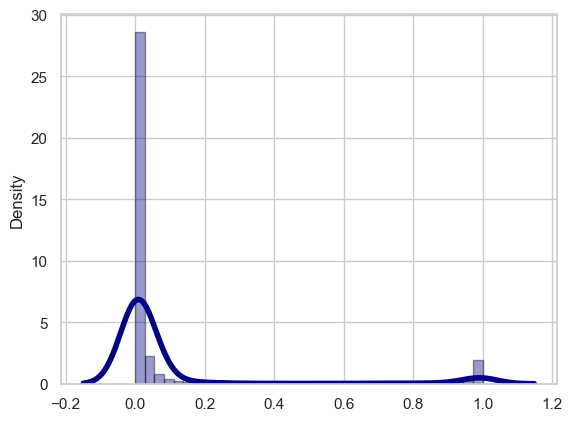

In [149]:
sns.distplot(p, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_6586/252634684.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temperature(p,tau = 20), hist=True, kde=True,


<Axes: ylabel='Density'>

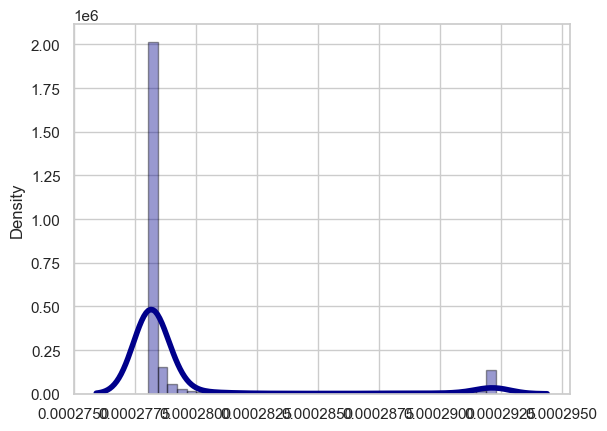

In [151]:

sns.distplot(temperature(p,tau = 20), hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

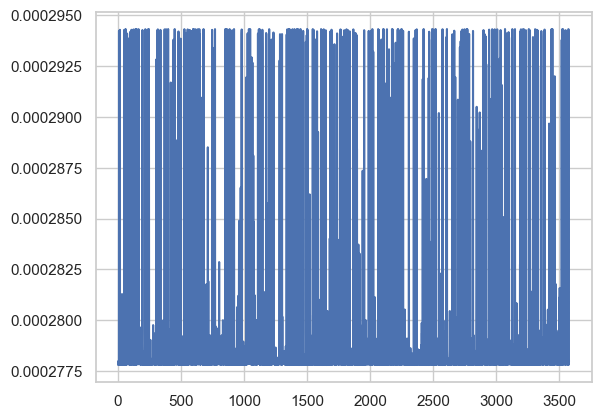

In [141]:
plt.plot(temperature(p,tau = 4))

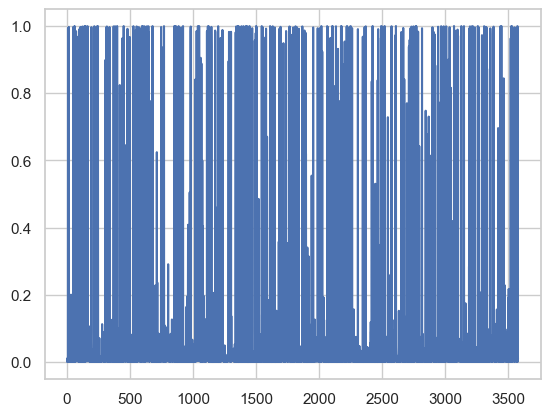

In [142]:
plt.plot(p)

On se propose de trouver la meilleure valeur de $\tau$ pour calibrer au mieux les prédictions.

## Trouver la meilleure valeur de $\tau$

Pour le faire, nous allons utiliser les capacités d'optimisations de PyTorch. Puisque la *loss* qu'optimise la régression logistique est la *Cross-Entropy*, on va chercher à optimiser cette même loss sur les prédictions du jeu de validation.

Commençons par préparer les objets dont nous aurons besoins:
* Initialiser l'objet qui représentera la cross-entropie
* Calculer les probabilités prédites pour chaque observations du dataset de validation et les transformer en logits

**Consigne** : Compléter le code ci-dessous.

In [ ]:
import torch
from torch.nn import CrossEntropyLoss

loss = CrossEntropyLoss()
probabilities_validation = model.predict_proba(...)
y_valid_tensor = torch.Tensor(np.array(...)).type(torch.LongTensor)
logits = torch.Tensor(logit(...))

Nous aurons également besoin d'initialiser le paramètre $\tau$ que l'on va apprendre et l'objet qui représentera l'optimizer. On décide de travailler avec [LBFGS](https://fr.wikipedia.org/wiki/Méthode_de_Broyden-Fletcher-Goldfarb-Shanno#:~:text=En%20mathématiques%2C%20la%20méthode%20de,algorithme%20à%20directions%20de%20descente.).

In [ ]:
tau_value = torch.nn.Parameter(torch.ones(1))
optimizer = torch.optim.LBFGS([tau_value], lr=0.01, max_iter=1000)

Calculons la valeur de la perte avant le post-processing :

In [ ]:
scaled = logits / tau_value.unsqueeze(1).expand(logits.size(0), logits.size(1))
loss_value = loss(scaled, y_valid_tensor)
print(f"Tau={tau_value.item()}, Loss={loss_value.item():0.4f}")

Mettons en place la boucle d'optimisation :

In [ ]:
def eval():
  optimizer.zero_grad()
  scaled = logits / tau_value.unsqueeze(1).expand(logits.size(0), logits.size(1))
  loss_value = loss(scaled, y_valid_tensor)
  loss_value.backward()
  return loss_value

optimizer.step(eval)

scaled = logits / tau_value.unsqueeze(1).expand(logits.size(0), logits.size(1))
loss_value = loss(scaled, y_valid_tensor)
print(f"Tau={tau_value.item()}, Loss={loss_value.item():0.4f}")

La fonction de perte est bien plus faible après ce processing en passant de 0.10 à 0.07. Avant de continuer, essayons de rendre plus simple cette optimisation en construisant une unique fonction.


**Consigne** : Rédiger une fonction qui prend en paramètres:
* *model*: modèle type scikit-learn, entraîné
* *X*: base de donnée à partir de laquelle les prédictions seront faites
* *y*: vecteur des prédictions attendues
Elle devra trouver la valeur optimale de température comme décrit ci-dessus.

In [ ]:
def temperature_scaling(model, X, y):
  ...

Maintenant que l'on sait trouver la valeur optimale de température pour optimiser la performance de la loss sur le jeu de validation, on aimerait savoir si ça se traduit de la même manière pour les autres datasets.

**Consigne** : pour chaque dataset, calculer la valeur de la loss avant et après le scaling par température.

On veut visualiser le changement du scaling de température sur les différentes métrique.
Pour cela, on construit une fonction qui va nous permettre de voir plus plusieurs seuils la valeur de la précision, du recall et du f1-score.

**Consigne** : Compléter la fonction.

In [ ]:
def plot_metrics(y_score, show=True):
  precision = []
  recall = []
  f1 = []
  thresholds = np.linspace(start=0.001, stop=0.99, num=50)

  for threshold in thresholds:
    y_pred = y_score[:, 1] > threshold
    precision.append(...)
    recall.append(...)
    f1.append(...)

  plt.axhline(y=np.max(f1), ls='--', alpha=0.8, color=sns.color_palette()[2])

  plt.plot(thresholds, precision, label="Precision")
  plt.plot(thresholds, recall, label="Recall")
  plt.plot(thresholds, f1, label="F1-Score", lw=2)

  plt.scatter(thresholds[np.argmax(f1)], precision[np.argmax(f1)])
  plt.scatter(thresholds[np.argmax(f1)], recall[np.argmax(f1)])
  plt.scatter(thresholds[np.argmax(f1)], max(f1))
  plt.ylim(0, 1)
  plt.legend()
  if show: plt.show()

**Consigne** : Exploiter la fonction complétée sur les prédictions sur le jeu de test. On veut voir la différence avant et après le scaling.

## Et la calibration ?

Jusqu'ici nous avons optimisé la loss avec un post-processing. Nous avons vu en cours que la performance en terme de calibration est également lié à un gain de performance suite à un post-processing.
Nous nous attendons donc à avoir une meilleure calibration après le scaling par la température.

Pour l'observer visuellement, nous pouvons utiliser la fonction *calibration_curve* de [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html).

**Consigne** : Visualiser la courbe de calibration avant et après le scaling, en traçant également le prédicteur parfaitement calibré.

## Pour continuer

Nous avons construit tout un tas de fonction pour faciliter le travail. Utilisez les fonctions pour reproduire l'étude avec d'autres algorithmes !